<a href="https://colab.research.google.com/github/yonbrand/Gait-Recognition/blob/main/tf_2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gait Segmentation
This code aims to take an acceleration raw data from daily-living, and extract the gait (walking) segmentation during the recording period.
This code is based on the original paper code: https://github.com/qinnzou/Gait-Recognition-Using-Smartphones/blob/master/code/gait-extraction/tf_seg_new.ipynb

Converted from TensorFlow to Pytorch

In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load the data

In [ ]:
def read_data(data_path):
    data = []
    # 1.txt
    file_names = os.listdir(data_path)
    file_names.sort(key=lambda x:int(x[:-4]))
    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        signal_data = np.loadtxt(file_path)
        data.append(signal_data)
    data = np.array(data).transpose(0, 2, 1)
    d_shape = data.shape
    return data.reshape(d_shape[0], 1, d_shape[1], d_shape[2])

def read_label(data_path):
    data = []
    # 1.txt
    file_names = os.listdir(data_path)
    file_names.sort(key=lambda x:int(x[:-10]))
    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        signal_data = np.loadtxt(file_path)
        data.append(signal_data)
    return np.array(data)

In [ ]:
#root = "drive//My Drive//danny//data"
path='/content/drive/MyDrive/DL- Danny & Yonatan/Datasets for gait segmentation/Dataset #7'
train_data_path = os.path.join(path, "train//train_data")
train_label_path = os.path.join(path, "train//train_label")
test_data_path = os.path.join(path, "test//test_data")
test_label_path = os.path.join(path, "test//test_label")

In [ ]:
os.path.isdir(train_data_path)


True

In [ ]:
train_data = read_data(train_data_path) # 519
train_label = read_label(train_label_path)
test_data = read_data(test_data_path) # 519
test_label = read_label(test_label_path)

In [ ]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
# np.save("train_data.npy", train_data)
# np.save("train_label.npy", train_label)
# np.save("test_data.npy", test_data)
# np.save("test_label.npy", test_label)

(519, 1, 6, 1024)
(519, 1024)
(58, 1, 6, 1024)
(58, 1024)


In [ ]:
train_data=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_data.npy")
train_label=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_label.npy")
test_data=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/test_data.npy")
test_label=np.load("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/test_label.npy")

In [ ]:
#ttt = torch.from_numpy(train_data[0:2]).to(device)
#ttt.size()

torch.Size([2, 1, 6, 1024])

Network Architecture

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[1,16])
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[1,16])
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[1,16])
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[1,16])

        self.convTranspose1 = nn.ConvTranspose2d(256, 128, (1, 2), stride=(1, 2))
        self.conv2_5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=[1,16])
        self.conv2_6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.convTranspose2 = nn.ConvTranspose2d(128, 64, (1, 2), stride=(1, 2))
        self.conv1_4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=[1,16])
        self.conv1_4_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])
        self.conv1_5 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=[6,1])
        self.conv1_6 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)

  # define forward function
    def forward(self, x):
        pad_x = nn.ReflectionPad2d((7, 8, 0, 0))(x)

        conv1_1 = F.relu( self.conv1_1(pad_x) )
        conv1_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_1)
        conv1_2 = F.relu( self.conv1_2(conv1_1) )

        conv2_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv1_2)

        conv2_1 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_1)
        conv2_2 = F.relu( self.conv2_1(conv2_1) )
        conv2_2 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_2)
        conv2_3 = F.relu( self.conv2_2(conv2_2) )

        conv3_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv2_3)

        conv3_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_1)
        conv3_2 = F.relu( self.conv3_1(conv3_1) )
        conv3_2 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_2)
        conv3_3 = F.relu( self.conv3_2(conv3_2) )
        conv3_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_3)
        conv3_4 = F.relu( self.conv3_2(conv3_3) )

        conv2_4_1 = self.convTranspose1(conv3_4)
        conv2_4 = torch.cat((conv2_4_1, conv2_3), 1)
        conv2_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_4)
        conv2_5 = F.relu( self.conv2_5(conv2_4) )
        conv2_5 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_5)
        conv2_6 = F.relu( self.conv2_6(conv2_5) )

        conv1_3_1 = self.convTranspose2(conv2_6)
        conv1_3 = torch.cat((conv1_2, conv1_3_1), 1)
        conv1_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_3)
        conv1_4 = F.relu( self.conv1_4(conv1_3) )
        conv1_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_4)
        conv1_4 = F.relu( self.conv1_4_2(conv1_4) )
        conv1_5 = F.relu( self.conv1_5(conv1_4) )
        conv1_6 = torch.sigmoid( self.conv1_6(conv1_5) )

        out = torch.reshape(conv1_6, (-1, 1024))

        return out

In [ ]:
# Training Parameters
learning_rate = 0.00001
num_steps = 50
batch_size = 32
display_step = 1
data_len = len(train_data)

In [ ]:
tensor_x_train = torch.Tensor(train_data).float().to(device) # transform to torch tensor
tensor_y_train = torch.Tensor(train_label).float().to(device)

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # create your dataloader


tensor_x_test = torch.Tensor(test_data).float().to(device) # transform to torch tensor
tensor_y_test = torch.Tensor(test_label).float().to(device)

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset) # create your dataloader



In [ ]:
model = Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def my_loss(y_,output_map):
  t0 = y_*torch.log(torch.clamp(output_map,1e-10,1.0))
  t1 = (1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0))
  return -torch.mean( t0 + t1)
  #return -torch.mean( y_*torch.log(torch.clamp(output_map,1e-10,1.0)) +(1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0)))

In [ ]:
def plot_model_loss( train_loss, title="train loss"):
    
    import matplotlib.pyplot as plt

    train = np.array(train_loss)
    #test = np.array(test_loss)

    plt.plot(train, color='blue', label='Training loss') 
    #plt.plot(test, color='red', label='Test loss') 
    
    plt.xlabel('Epoch')  
    plt.ylabel('loss')  

    plt.title(title) 

    plt.legend()
    plt.show()

In [ ]:
def check_acc(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            features, labels = data
            outputs = model(features)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    acc = (100 * correct / total)
    if loader=='train_loader':
      print('Accuracy on the training set is : %.3f %%' % acc)
    elif loader=='test_loader':
      print('Accuracy on the validation set is: %.3f %%' % acc)
    
    return acc

# Train the model

In [ ]:
all_train_loss = []
all_test_loss = []

for epoch in range(num_steps):
      
  model.train()
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    preds = model(data)

    #loss = F.cross_entropy(preds, labels.to(device))
    loss = my_loss(labels, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    # if batch_idx % 5 == 0:    
    #      print('[%d, %5d] loss: %.3f' %
    #            (epoch, batch_idx, bach_loss))

  all_train_loss.append(bach_loss)
  model.eval()
  
  # test_preds = model(tensor_x_test)
  # test_loss = my_loss(tensor_y_test, test_preds)
  # all_test_loss.append(test_loss)

  #print("epoch %d,  train loss : %.3f, test loss : %.3f" % (epoch, bach_loss, test_loss))  
  print("epoch %d,  train loss : %.3f," % (epoch, bach_loss))  


  #train_acc.append( check_acc(model, train_loader) )
  #validation_acc.append( check_acc(model, test_loader) ) 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0,  train loss : 0.686,
epoch 1,  train loss : 0.707,
epoch 2,  train loss : 0.709,
epoch 3,  train loss : 0.676,
epoch 4,  train loss : 0.633,
epoch 5,  train loss : 0.569,
epoch 6,  train loss : 0.692,
epoch 7,  train loss : 0.445,
epoch 8,  train loss : 0.504,
epoch 9,  train loss : 0.601,
epoch 10,  train loss : 0.496,
epoch 11,  train loss : 0.462,
epoch 12,  train loss : 0.377,
epoch 13,  train loss : 0.307,
epoch 14,  train loss : 0.458,
epoch 15,  train loss : 0.231,
epoch 16,  train loss : 0.574,
epoch 17,  train loss : 0.529,
epoch 18,  train loss : 0.571,
epoch 19,  train loss : 0.306,
epoch 20,  train loss : 0.217,
epoch 21,  train loss : 0.187,
epoch 22,  train loss : 0.512,
epoch 23,  train loss : 0.256,
epoch 24,  train loss : 0.343,
epoch 25,  train loss : 0.611,
epoch 26,  train loss : 0.325,
epoch 27,  train loss : 0.364,
epoch 28,  train loss : 0.173,
epoch 29,  train loss : 0.279,
epoch 30,  train loss : 0.350,
epoch 31,  train loss : 0.319,
epoch 32,  train l

In [ ]:
torch.save(model.state_dict(), 'gait_extraction.pt') #saving the trained model  

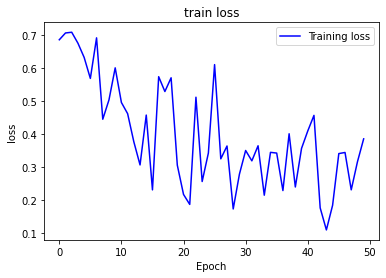

In [ ]:
plot_model_loss(all_train_loss)

# Load trained model

In [ ]:
from google.colab import files 
uploaded = files.upload() #upload the trained models files


Saving gait_extraction.pt to gait_extraction.pt


In [ ]:
#load one of the models
model=Network().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/gait_extraction.pt')) #load the corresponding model
model.to(device)

Network(
  (conv1_1): Conv2d(1, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(1, 16), stride=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose1): ConvTranspose2d(256, 128, kernel_size=(1, 2), stride=(1, 2))
  (conv2_5): Conv2d(256, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_6): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose2): ConvTranspose2d(128, 64, kernel_size=(1, 2), stride=(1, 2))
  (conv1_4): Conv2d(128, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_4_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_5): Conv2d(64, 256, kernel_size=(6, 1), stride=(1, 1))
  (conv1_6): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
all_preds=[]
for batch_idx, (data, labels) in enumerate(test_dataloader):
  model.eval()
  preds = model(data)
  all_preds.append(preds)

all_preds=torch.cat(all_preds, dim=1)

In [ ]:
round_preds=torch.round(all_preds).view(-1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_test_reshape=tensor_x_test.reshape(6,59392)
y_test_reshape=tensor_y_test.reshape(59392)

In [ ]:
acc= torch.sqrt(x_test_reshape[0]**2+x_test_reshape[1]**2+x_test_reshape[2]**2) #the acceleration magnitude

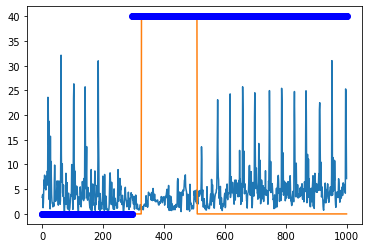

In [ ]:
#visualizing raw_data
plt.plot(acc[:1000].cpu())
plt.plot(y_test_reshape[:1000].cpu()*40)
plt.plot(round_preds[:1000].cpu()*40,'bo')
plt.show()
#plt.savefig('fig.png')

In [ ]:
#extracting only the gait segments for follow-up analysis
gait_segments= acc[round_preds==1]

# Gait Cycle Segmentation

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def cycle_seg(data):
  fs=50 #sampling rate, in Hz
  peaks, _=find_peaks(data, distance=0.8*fs)
  threshold=10 #m/s**2
  used_peaks=[]
  for pks in peaks:
    if data[pks]>threshold:
      used_peaks.append(pks)  
  return torch.tensor(used_peaks)

In [ ]:
peaks=cycle_seg(gait_segments.cpu())

In [ ]:
peaks

tensor([  227,   280,   321,   362,   402,   450,   490,   570,   615,   655,
          700,   745,   790,   832,   875,   915,   955,  1000,  1055,  1107,
         1156,  1237,  1319,  1386,  1429,  1469,  1509,  1555,  1601,  1644,
         1685,  1766,  1815,  1906,  1946,  1987,  2037,  2077,  2119,  2159,
         2207,  2247,  2289,  2331,  2382,  3300,  3342,  3415,  3480,  3521,
         3581,  3629,  3703,  3761,  3818,  3890,  3978,  4134,  4216,  4320,
         4390,  4453,  4529,  4581,  4635,  4688,  4733,  4786,  4838,  4889,
         4941,  4993,  5045,  5098,  5152,  5227,  5299,  5360,  5414,  5483,
         5539,  5596,  5652,  5711,  5761,  5819,  5870,  5933,  5989,  6044,
         6103,  6162,  6222,  7218,  7276,  7330,  7390,  7449,  7507,  7644,
         7704,  7754,  7828,  7883,  7937,  7996,  8053,  8102,  8146,  8210,
         8271,  8333,  8506,  8551,  8597,  8651,  8723,  8763,  8804,  8848,
         8891,  8937,  9011,  9067,  9117,  9165,  9233,  9469, 